In [203]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pytz

from datetime import datetime
from pandas import DataFrame, Series
from scipy.stats import norm, shapiro, probplot, chi2
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.dates import DateFormatter

### Helper Functions 

In [170]:
def float_to_time(time_float):
    # Check if the input is within the valid range (0 < x < 24)
    if 0 <= time_float < 24:
        # Convert float to hours, minutes, and seconds
        hours = int(time_float)
        minutes = int((time_float - hours) * 60)
        seconds = int(((time_float - hours) * 60 - minutes) * 60)
        
        # Format the time as HH:MM:SS
        time_string = '{:02}:{:02}:{:02}'.format(hours, minutes, seconds)
        return time_string
    else:
        return "Invalid input. Time must be between 0 and 24."


def convert_timestamp(row):
    if row['Region'].lower() == 'asia-east':
        target_tz = pytz.timezone('Australia/Sydney')
    elif row['Region'].lower() == 'asia-west':
        target_tz = pytz.timezone('Asia/Karachi')
    elif row['Region'].lower() == 'us-central':
        target_tz = pytz.timezone('America/Chicago')
    else:
        target_tz = pytz.timezone('Europe/London')
        
    # localized_time = pytz.utc.localize(row['Timestamp'])  # Localize the UTC timestamp
    # local_time = row['Timestamp'].astimezone(target_tz)  # Convert to local time
    
    localized_time = row['Timestamp'].astimezone(target_tz)  # Convert to local time
    return localized_time  # Return the localized_time directly
    # return local_time
    



## Beginning of Analysis

In [171]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timezone_names = ['East Asia', 'West Asia', 'Europe West', 'America']
current_time = datetime.now()
current_time = current_time.hour + current_time.minute / 60 + current_time.second / 3600

df = pd.read_csv('BRTimeHistory_1699215361_UTC.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True).dt.tz_convert('UTC')

df['Timestamp'] = df.apply(lambda row: convert_timestamp(row), axis=1)
print(df.head())
# df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.tz_localize(None)
# df['Timestamp'] = df['Timestamp'].dt.to_pydatetime()

pydatetimes = []
for ts in df['Timestamp']:
    pydatetimes.append(ts.tz_localize(None).to_pydatetime())
df['Timestamp'] = pydatetimes

df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time
df['Day of Week'] = df['Timestamp'].dt.dayofweek
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second
df['Time int'] = df['Timestamp'].dt.hour + df['Timestamp'].dt.minute / 60 + df['Timestamp'].dt.second / 3600
# df.drop('Region', axis=1, inplace=True)
df.drop('Moment ID', axis=1, inplace=True)
# df.drop('Time.dt.hour + europe['Timestamp'].dt.minute / 60stamp', axis=1, inplace=True)
df

               Moment ID       Region                  Timestamp
0  sTuCKFQQ1MzpT2OJ1uXvc    asia-west  2023-11-08 12:50:22+05:00
1  0NF_O4sZsn3Hv2Wj-8Ubz   us-central  2023-11-07 20:17:54-06:00
2  ZbfDE6jJS_bCbN_-y7GJm    asia-east  2023-11-08 10:35:10+11:00
3  U1S5Rhp4bv3gauugtnMHK    asia-west  2023-11-07 18:18:23+05:00
4  tFWgnD4aRTgpSPrRZ1VUF  europe-west  2023-11-07 12:15:54+00:00


,Region,Timestamp,Date,Time,Day of Week,Hour,Minute,Second,Time int
0,asia-west,2023-11-08 12:50:22,2023-11-08,12:50:22,2,12,50,22,12.839444
1,us-central,2023-11-07 20:17:54,2023-11-07,20:17:54,1,20,17,54,20.298333
2,asia-east,2023-11-08 10:35:10,2023-11-08,10:35:10,2,10,35,10,10.586111
3,asia-west,2023-11-07 18:18:23,2023-11-07,18:18:23,1,18,18,23,18.306389
4,europe-west,2023-11-07 12:15:54,2023-11-07,12:15:54,1,12,15,54,12.265000
...,...,...,...,...,...,...,...,...,...
355,europe-west,2023-08-11 10:44:06,2023-08-11,10:44:06,4,10,44,6,10.735000
356,asia-west,2023-08-11 13:15:13,2023-08-11,13:15:13,4,13,15,13,13.253611
357,asia-east,2023-08-11 17:21:28,2023-08-11,17:21:28,4,17,21,28,17.357778
358,us-central,2023-08-10 17:44:46,2023-08-10,17:44:46,3,17,44,46,17.746111


In [172]:
grouped = df.groupby('Region')
dataframes = [group for _, group in grouped]
east_asia, west_asia, europe, america = dataframes

In [173]:
# type(convert_timestamp(america.iloc[0]))

In [174]:
europe

,Region,Timestamp,Date,Time,Day of Week,Hour,Minute,Second,Time int
4,europe-west,2023-11-07 12:15:54,2023-11-07,12:15:54,1,12,15,54,12.265000
7,europe-west,2023-11-06 18:36:58,2023-11-06,18:36:58,0,18,36,58,18.616111
12,europe-west,2023-11-05 09:57:35,2023-11-05,09:57:35,6,9,57,35,9.959722
16,europe-west,2023-11-04 12:50:08,2023-11-04,12:50:08,5,12,50,8,12.835556
19,europe-west,2023-11-03 12:08:43,2023-11-03,12:08:43,4,12,8,43,12.145278
...,...,...,...,...,...,...,...,...,...
343,europe-west,2023-08-14 12:43:10,2023-08-14,12:43:10,0,12,43,10,12.719444
347,europe-west,2023-08-13 10:27:18,2023-08-13,10:27:18,6,10,27,18,10.455000
351,europe-west,2023-08-12 22:03:53,2023-08-12,22:03:53,5,22,3,53,22.064722
355,europe-west,2023-08-11 10:44:06,2023-08-11,10:44:06,4,10,44,6,10.735000


In [175]:
mean_moment = europe['Time int'].mean()
print(mean_moment)
europe[['Hour', 'Minute', 'Second', 'Time int']].describe()

14.201067901234566


,Hour,Minute,Second,Time int
count,90.000000,90.000000,90.000000,90.000000
mean,13.722222,28.255556,28.511111,14.201068
std,3.659765,16.950398,18.036321,3.655936
min,5.000000,1.000000,1.000000,5.191111
25%,11.000000,13.250000,11.000000,11.306875
50%,14.000000,27.000000,27.000000,14.035000
75%,17.000000,42.750000,44.750000,17.306875
max,22.000000,59.000000,59.000000,22.702222


In [193]:
summaries = []

for idx, dataframe in enumerate(dataframes, start=1):
    summary = dataframe['Time int'].describe().to_frame()
    summary.columns = [f'{timezone_names[idx-1]}']  # Rename the column to indicate DataFrame number
    summaries.append(summary)

summary_df = pd.concat(summaries, axis=1)
print(summary_df)

       East Asia  West Asia  Europe West    America
count  90.000000  90.000000    90.000000  90.000000
mean   16.018994  15.318515    14.201068  16.112880
std     3.503189   3.291111     3.655936   3.364134
min     9.352500   9.056667     5.191111   9.280278
25%    13.554861  12.877153    11.306875  13.350972
50%    15.968889  14.982083    14.035000  16.098194
75%    18.626319  17.412083    17.306875  18.857083
max    23.916667  22.024722    22.702222  23.071111


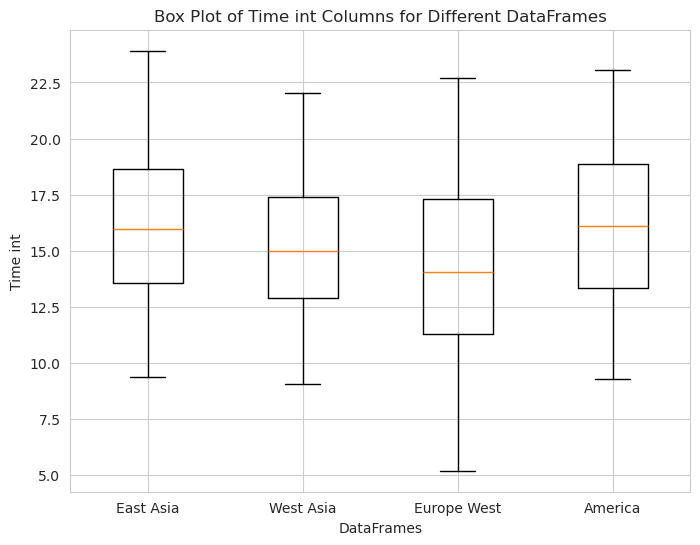

In [195]:
time_int_columns = [dataframe['Time int'] for dataframe in dataframes]
plt.figure(figsize=(8, 6))
plt.boxplot(time_int_columns, labels=[tz for tz in timezone_names])
plt.xlabel('DataFrames')
plt.ylabel('Time int')
plt.title('Box Plot of Time int Columns for Different DataFrames')
plt.show()

### Date vs Time Plot

DataFrame East Asia: q1: 13.55486111111111; q2: 15.968888888888888; q3: 18.626319444444444
DataFrame West Asia: q1: 12.877152777777777; q2: 14.982083333333334; q3: 17.412083333333335
DataFrame Europe West: q1: 11.306875000000002; q2: 14.035; q3: 17.306874999999998
DataFrame America: q1: 13.350972222222222; q2: 16.098194444444445; q3: 18.857083333333332


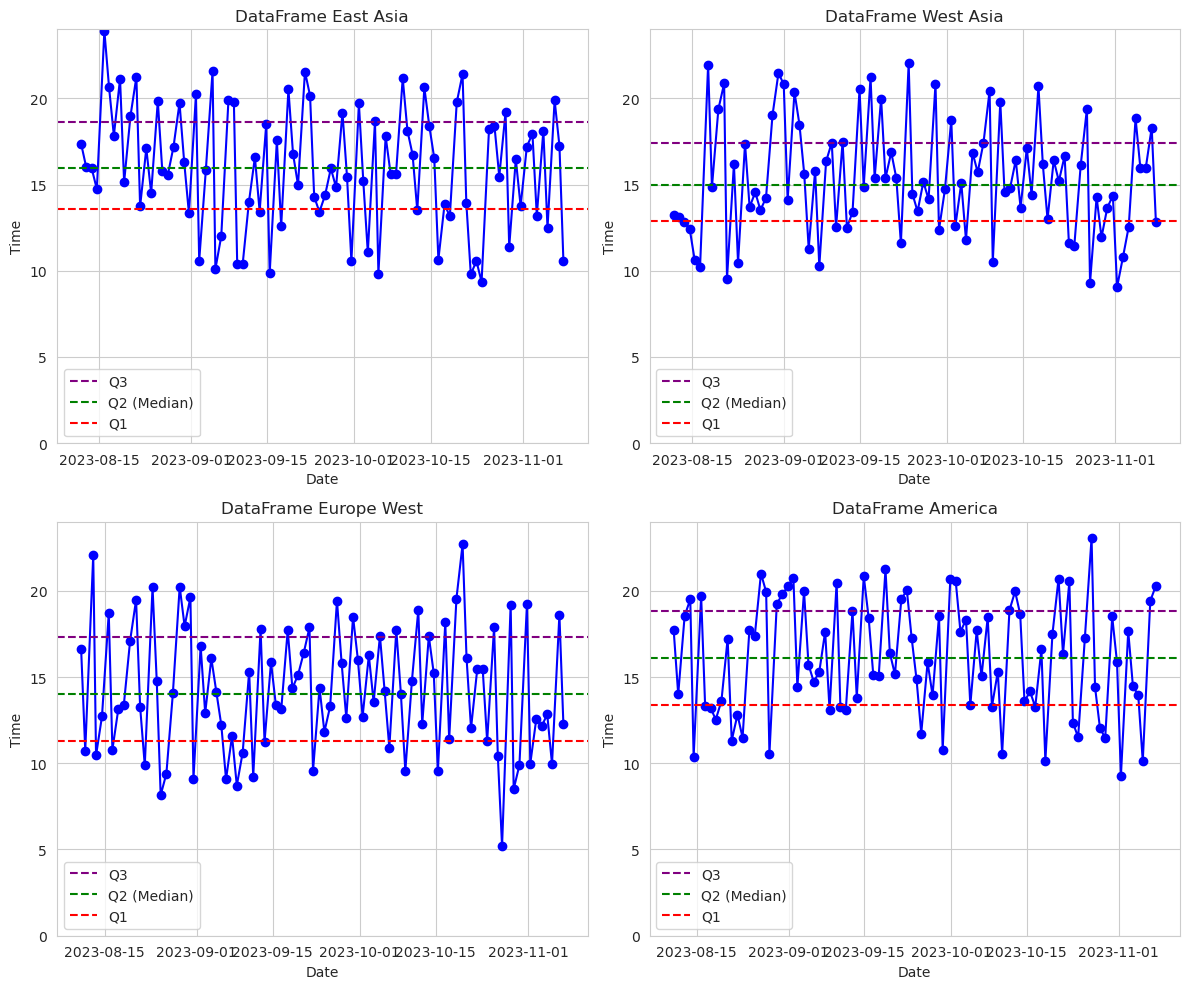

In [199]:
def plot_date_vs_time_subplot(ax, df, title):
    q1 = np.percentile(df['Time int'], 25)
    q2 = np.percentile(df['Time int'], 50)
    q3 = np.percentile(df['Time int'], 75)
    iqr = q3 - q1
    print(f'{title}: q1: {q1}; q2: {q2}; q3: {q3}')

    ax.plot(df['Timestamp'], df['Time int'], marker='o', linestyle='-', color='b')
    ax.axhline(y=q3, color='purple', linestyle='--', label='Q3')
    ax.axhline(y=q2, color='g', linestyle='--', label='Q2 (Median)')
    ax.axhline(y=q1, color='r', linestyle='--', label='Q1')
    ax.set_xlabel('Date')
    ax.set_ylabel('Time')
    ax.set_ylim(0,24)
    ax.set_title(title)
    ax.legend()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over subplots and plot each DataFrame
for i, ax in enumerate(axs.flat):
    if i < len(dataframes):
        df_ = dataframes[i]
        title = f'DataFrame {timezone_names[i]}'
        plot_date_vs_time_subplot(ax, df_, title)
    else:
        ax.axis('off')  # Turn off extra subplots if there are fewer DataFrames than subplots

plt.tight_layout()
plt.show()

### Time distribution 

/tmp/ipykernel_37929/2404733859.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(df['Time int'], ax=ax_twin, color='r', kernel='gau', bw_method='silverman')
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_37929/2404733859.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.

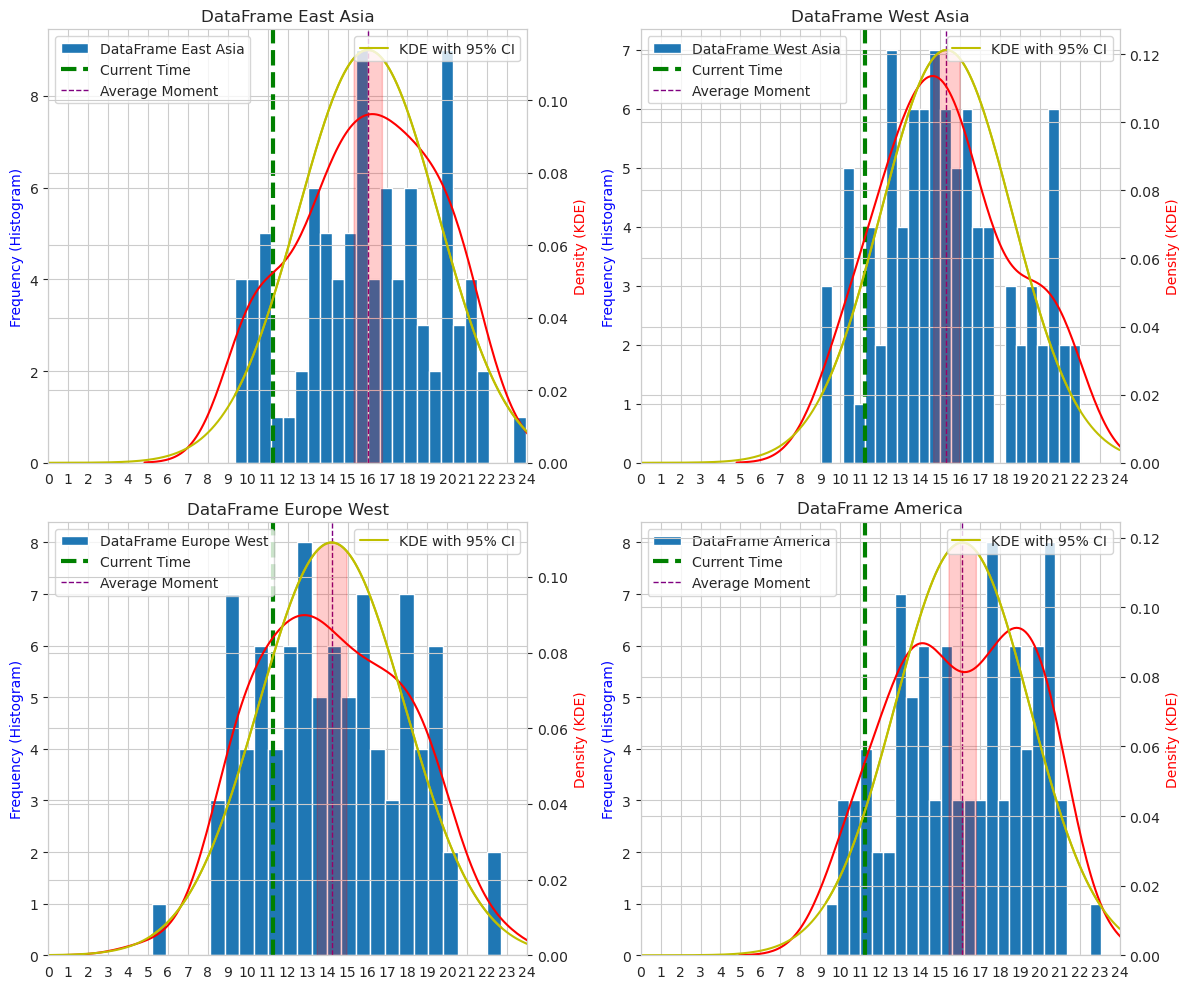

/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


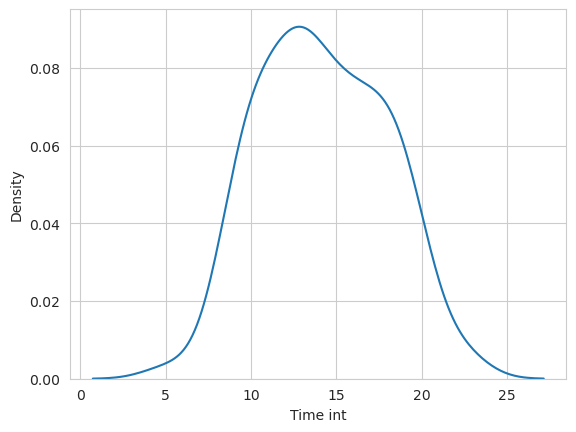

In [207]:

current_time = datetime.now()
current_time = current_time.hour + current_time.minute / 60 + current_time.second / 3600

def plot_dataframe_subplot(ax, df, title):
    mean, std = df['Time int'].mean(), df['Time int'].std()
    xmin, xmax = df['Time int'].min(), df['Time int'].max()
    x = np.linspace(xmin, xmax, 1000)
    pdf = norm.pdf(x, mean, std)

    ax.hist(df['Time int'], bins=24, label=title)
    ax.set_xlim(0, 24)
    ax.set_xticks(range(25))
    ax_twin = ax.twinx()
    sns.kdeplot(df['Time int'], ax=ax_twin, color='r', kernel='gau', bw_method='silverman')
    ax_twin.plot(x, pdf, color='y')
    
    
    # Calculate the 95% confidence interval for the mean and standard deviation
    conf_interval_mean = norm.interval(0.95, loc=mean, scale=std / np.sqrt(len(df)))
    conf_interval_std = std * np.sqrt(len(df) / chi2.ppf(0.025, df=len(df) - 1)), std * np.sqrt(len(df) / chi2.ppf(0.975, df=len(df) - 1))
    
    # KDE plot with 95% confidence interval
    x = np.linspace(0, 24, 1000)
    kde = norm.pdf(x, loc=mean, scale=std)
    ax_twin.plot(x, kde, color='y', label='KDE with 95% CI')
    ax_twin.fill_between(x, kde, where=[(xi >= conf_interval_mean[0] and xi <= conf_interval_mean[1]) for xi in x], alpha=0.2, color='r')
    
    
    
    ax.set_ylabel('Frequency (Histogram)', color='blue')
    ax_twin.set_ylabel('Density (KDE)', color='red')
    ax.axvline(current_time, color='green', linestyle='--', linewidth=3, label='Current Time')
    ax.axvline(mean, color='purple', linestyle='--', linewidth=1, label='Average Moment')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    ax.set_title(title)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(axs.flat):
    if i < len(dataframes):
        df_ = dataframes[i]
        title = f'DataFrame {timezone_names[i]}'
        plot_dataframe_subplot(ax, df_, title)
    else:
        ax.axis('off')  # Turn off extra subplots if there are fewer DataFrames than subplots

plt.tight_layout()
plt.show()


kde_data_europe_time_int = sns.kdeplot(europe['Time int']).get_lines()[0].get_data()

### Get hourly probability

In [178]:
def getHourProbability(start: int, df: DataFrame=europe ) -> float: 
    end = start + 1  # 1 hour window
    count = df['Time int'].count()
    series = df['Time int']
    occurrences_in_window = series[(series >= start) & (series < end)].count()
    p = occurrences_in_window / count
    return p

getHourProbability(9)

0.12222222222222222

### Remaining hours probability

/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10.643333333333333


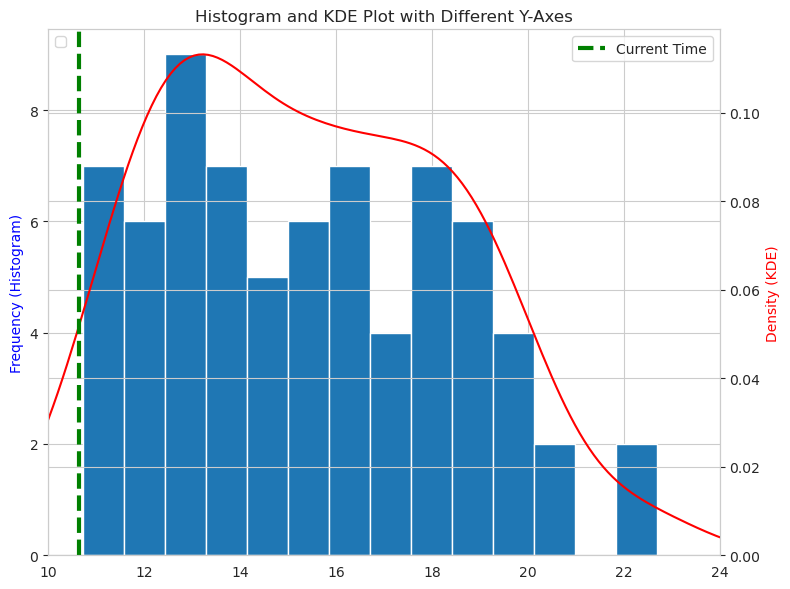

In [200]:

number_of_bins = 24 - math.floor(current_time)
print(current_time)
series = europe['Time int']
filtered_series = series[series >= current_time]

fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(filtered_series, bins=number_of_bins)
plt.xlim(int(current_time), 24)
ax2 = ax1.twinx()
sns.kdeplot(filtered_series, ax=ax2, color='r')
ax1.set_ylabel('Frequency (Histogram)', color='blue')
ax2.set_ylabel('Density (KDE)', color='red')
plt.title('Histogram and KDE Plot with Different Y-Axes')
plt.axvline(current_time, color='green', linestyle='--', linewidth=3, label='Current Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show() 

### Day of the Week analysis

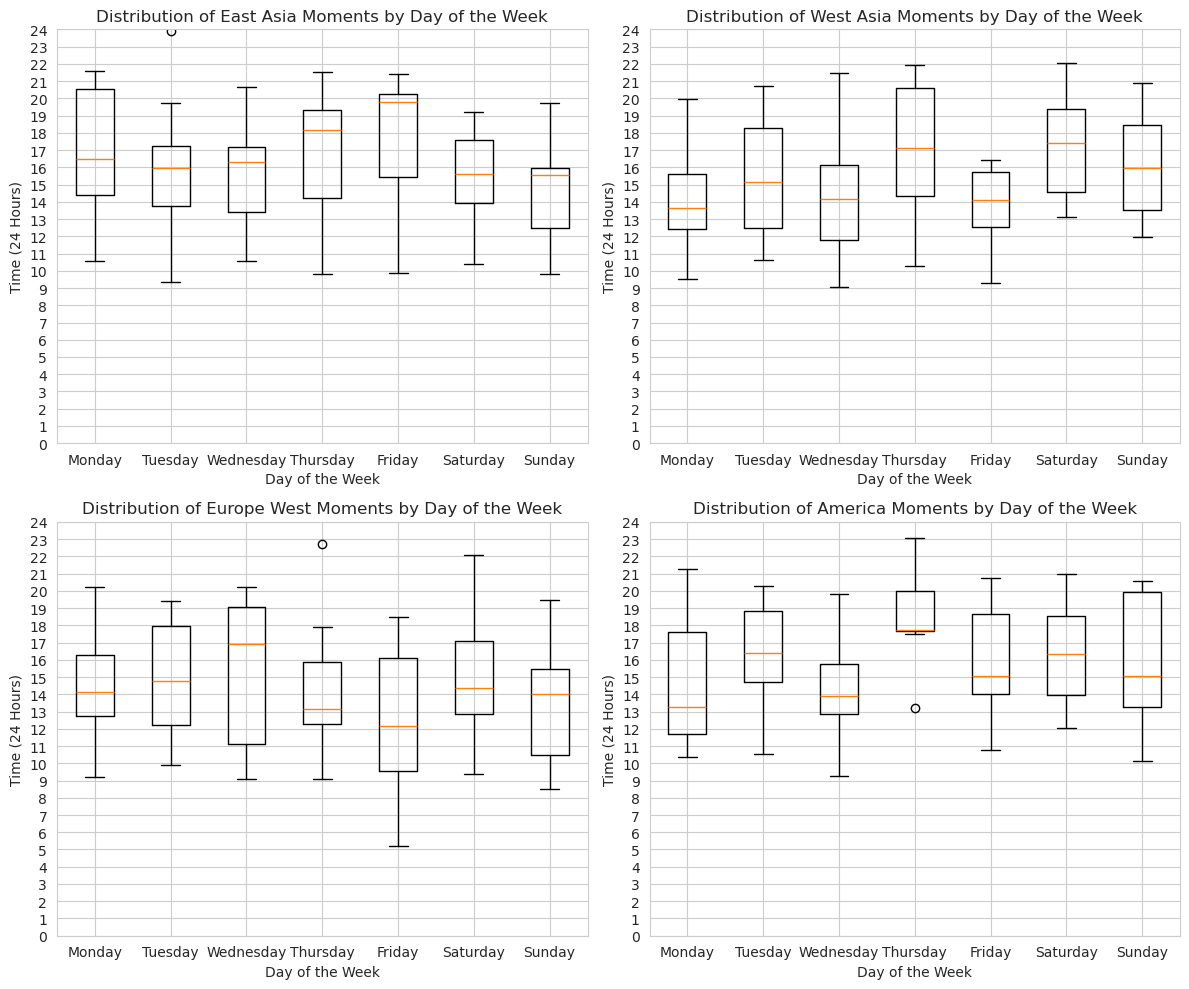

In [198]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
for idx, dataframe in enumerate(dataframes):
    row = idx // 2
    col = idx % 2
    data_to_plot = []

    grouped_data = dataframe.groupby('Day of Week')
    for day, group in grouped_data:
        data_to_plot.append(group['Time int'])
    
    # Create boxplot for the current DataFrame
    axes[row, col].boxplot(data_to_plot, labels=day_names)
    axes[row, col].set_yticks(range(25))
    axes[row, col].set_xlabel('Day of the Week')
    axes[row, col].set_ylabel('Time (24 Hours)')
    axes[row, col].set_ylim(0, 24)
    axes[row, col].set_title(f'Distribution of {timezone_names[idx]} Moments by Day of the Week')

# Adjust layout
plt.tight_layout()
plt.show()

### Minute and Second analysis

/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tctb/.conda/envs/cal/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

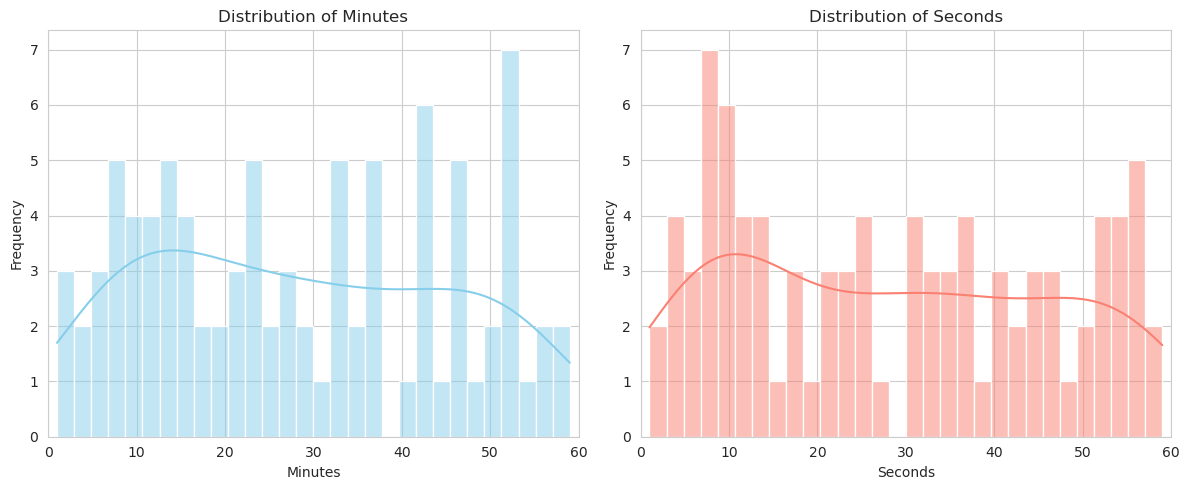

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
number_of_bins = 30

# Plot histogram for 'minutes' column
sns.histplot(europe['Minute'], ax=axs[0], color='skyblue', kde=True, bins=number_of_bins)
axs[0].set_title('Distribution of Minutes')
axs[0].set_xlabel('Minutes')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 60)

# Plot histogram for 'seconds' column
sns.histplot(europe['Second'], ax=axs[1], color='salmon', kde=True, bins=number_of_bins)
axs[1].set_title('Distribution of Seconds')
axs[1].set_xlabel('Seconds')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 60)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Shapiro-Wilk Test

In [182]:
data = europe['Hour'].sort_values(ascending=True)
mean, std = europe['Hour'].mean(), europe['Time int'].std()
pdf = norm.pdf(data, mean, std)

stat, p_value = shapiro(pdf)
alpha = 0.05

print(f'Shapiro-Wilk test statistic: {stat:.3f}')
print(f'P-value: {p_value:.3f}')

if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")

Shapiro-Wilk test statistic: 0.913
P-value: 0.000
The data does not appear to be normally distributed (reject H0)


### Q-Q plot between KDE generated distribution and Normal distribution

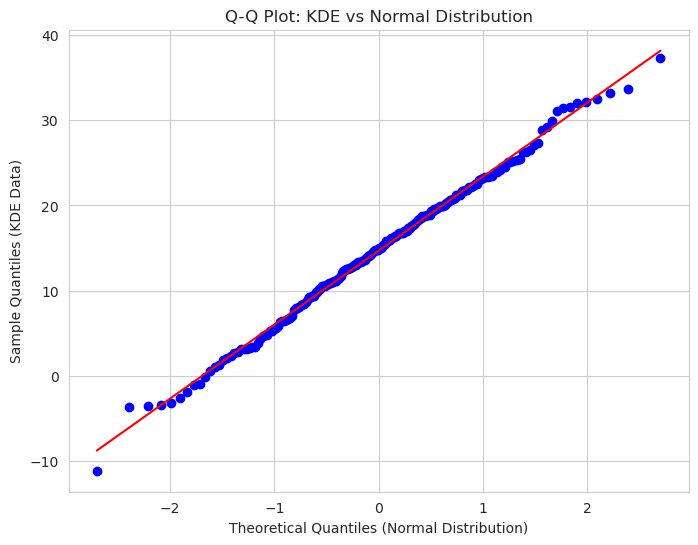

In [183]:
x_values, y_values = kde_data_europe_time_int
normal_quantiles = np.random.normal(loc=np.mean(x_values), scale=np.std(x_values), size=len(x_values))

plt.figure(figsize=(8, 6))
probplot(normal_quantiles, dist='norm', plot=plt) 
plt.title('Q-Q Plot: KDE vs Normal Distribution')
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Sample Quantiles (KDE Data)')
plt.show()